In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
import tensorflow_probability as tfp
#from tf_keras import layers, Model, models
from tensorflow.keras import layers, Model, models, metrics, optimizers
#from tensorflow import keras
import keras
import tensorflow_datasets as tfds2
import datetime
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import sys
import copy
import itertools
import gc
import os
import json
import inspect
import shutil
tf.random.set_seed(1)

2024-12-08 21:55:34.569134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733691334.588843   84418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733691334.595189   84418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 21:55:34.620144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Num GPUs Available:  1


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading + processing

In [2]:
parental_geno_data = pd.read_csv("./data/parent_genos_ordered.csv")
child_geno_data = pd.read_csv("./data/all_child_genos_ordered.csv")

# Get population per sample, split populations into oop and train
pop_per_sample = child_geno_data["pop"].to_numpy()
test_pops = np.random.choice(np.unique(pop_per_sample), 8)
train_pops_idx = ~np.isin(pop_per_sample, test_pops)
test_geno_pops = pop_per_sample[np.isin(pop_per_sample, test_pops)]

In [3]:
all_geno_combs = list(itertools.product(["A", "T", "G", "C"], ["A", "T", "G", "C"])) + [("-", "-")]
all_geno_combs = np.unique(["".join(np.sort(cur_genos)) for cur_genos in all_geno_combs])

In [4]:
p1_ids = child_geno_data['p1_id'].to_numpy()
p2_ids = child_geno_data['p2_id'].to_numpy()
p_pop = child_geno_data['pop'].to_numpy()

# Parent 1 is technically always maize B73
# -> shuffle parent ids so model isnt fed same p1 input across all samples
p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
[np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

# Extract parental genos from pandas df, split to train and OOP
parental_geno_np = parental_geno_data.iloc[:, 1:].to_numpy()
p1_genos_np = np.stack([parental_geno_np[cur_p-1, :-1] for cur_p in p_genos_ids[:, 0]], axis =0 )
p2_genos_np = np.stack([parental_geno_np[cur_p-1, :-1] for cur_p in p_genos_ids[:, 1]], axis =0 )
p1_genos_np_train = p1_genos_np[train_pops_idx, :]
p1_genos_np_test = p1_genos_np[~train_pops_idx, :]
p2_genos_np_train = p2_genos_np[train_pops_idx, :]
p2_genos_np_test = p2_genos_np[~train_pops_idx, :]
p_pop_test = p_pop[~train_pops_idx]
p_pop_train = p_pop[train_pops_idx]

# Split child geno types into train + (in population) evaluation error and OOP
# IP data == eval, OOP == test
child_geno_np_train_eval = child_geno_data.iloc[train_pops_idx, 2:-2].to_numpy()
child_geno_np_test = child_geno_data.iloc[~train_pops_idx, 2:-2].to_numpy()
child_geno_np = child_geno_data.iloc[:, 2:-2].to_numpy()

In [5]:
# Construct np arrays from individual arrays, split train+eval array into individual
# train and eval arrays
# Technically this could be achieved way simpler by splitting a tf dataset, but
# since the genotype arrays dont contain the population id this is the only way i found
# to track them
 
full_sample_np_train_eval = np.stack([child_geno_np_train_eval,
    p1_genos_np_train,
    p2_genos_np_train],
    axis = 1)
eval_samples = np.random.choice(range(full_sample_np_train_eval.shape[0]),
                                size = 1000, replace = False)
full_sample_np_train = np.delete(full_sample_np_train_eval, eval_samples, axis = 0)
child_geno_np_eval = child_geno_np_train_eval[eval_samples, ...]
child_geno_np_train = np.delete(child_geno_np_train_eval, eval_samples, axis = 0)

train_pops = np.delete(p_pop_train, eval_samples)
eval_pops = p_pop_train[eval_samples]
full_sample_np_eval = full_sample_np_train_eval[eval_samples, ...]

full_sample_np_test = np.stack([child_geno_np_test,
    p1_genos_np_test,
    p2_genos_np_test],
    axis = 1)
full_sample_np = np.stack([child_geno_np,
    p1_genos_np,
    p2_genos_np],
    axis = 1)

In [6]:
# Convert data into one hot encodings and stack to tensors

child_geno_one_hot_train = [np.float16(child_geno_np_train == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_train = tf.stack(child_geno_one_hot_train, axis = -1)
geno_np_layers_train = [np.float16(full_sample_np_train == cur_class) for cur_class in all_geno_combs]
geno_tensor_train = tf.stack(geno_np_layers_train, axis = -1)

child_geno_one_hot_eval = [np.float16(child_geno_np_eval == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_eval = tf.stack(child_geno_one_hot_eval, axis = -1)
geno_np_layers_eval = [np.float16(full_sample_np_eval == cur_class) for cur_class in all_geno_combs]
geno_tensor_eval = tf.stack(geno_np_layers_eval, axis = -1)

child_geno_one_hot_test = [np.float16(child_geno_np_test == cur_class) for cur_class in all_geno_combs]
child_geno_tensor_test = tf.stack(child_geno_one_hot_test, axis = -1)
geno_np_layers_test = [np.float16(full_sample_np_test == cur_class) for cur_class in all_geno_combs]
geno_tensor_test = tf.stack(geno_np_layers_test, axis = -1)

child_geno_one_hot = [np.float16(child_geno_np == cur_class) for cur_class in all_geno_combs]
child_geno_tensor = tf.stack(child_geno_one_hot, axis = -1)
geno_np_layers = [np.float16(full_sample_np == cur_class) for cur_class in all_geno_combs]
geno_tensor = tf.stack(geno_np_layers, axis = -1)


I0000 00:00:1733691345.230640   84418 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1733691345.305954   84418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [7]:
# train_dataset -> actual training
# eval -> test dataset without seeing children, shared parents with train_dataset (IP)
# test_dataset -> test dataset without seeing children + parents (OOP)

full_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor_train, child_geno_tensor_train))
full_dataset = full_dataset.shuffle(buffer_size=int(1e6))
train_dataset = full_dataset
train_dataset = train_dataset.batch(256, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((geno_tensor_test, child_geno_tensor_test))
test_dataset = test_dataset.shuffle(buffer_size=int(1e6))
test_dataset = test_dataset.batch(geno_tensor_test.shape[0], drop_remainder=True)

## Model definition

In [8]:
# Moved defintions to separate python scripts
files_to_load = ["cur_helpers.py", "cur_encoder.py", "cur_decoder.py", "cur_autoencoder.py", "custom_lr_on_callback.py"]
for cur_file in files_to_load:
    execfile(cur_file)
cur_base_dir = "./data/var_autoencoder/vanilla_vae_lim_kl_scale/"
if not os.path.isdir(cur_base_dir):
    os.mkdir(cur_base_dir)

## Grid testing
* Deprecated, need to rerun once satisfying VAE structure found
* Test hyperparamters in grid like fashion

In [ ]:

def fit_per_para(encoder_w, decoder_d, epochs = 100):
    print("###########################################")
    print(f"current encoder width: {encoder_w}")
    print(f"current decoder depth: {decoder_d}")
    true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))

    # used for focal loss
    inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))

    focal_loss = tf.keras.losses.CategoricalCrossentropy(axis = 1,
                                                          from_logits=False)

    focal_optimizer = optimizers.Lion(learning_rate=1e-4)
    model = autoencoder(100, encoder_width=encoder_w, decoder_depth=decoder_d)
    model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                      metrics=[metrics.CategoricalAccuracy()])
    model_train_loss = model.fit(train_dataset, epochs=epochs, shuffle=True,
                                 validation_data = test_dataset)
    true_classes = np.argmax(test_labels, axis = 1).reshape((-1))
    pred_classes = np.argmax(model(test_labels), axis = 1).reshape((-1))
    class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
           np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
    print(class_acc)
    print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
    out = [class_acc, model_train_loss]
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return out

In [ ]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 100) for cur_paras in paras]

###########################################
encoder_w: 5
decoder_d: 5
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - categorical_accuracy: 0.0014 - loss: 1.1271 - val_categorical_accuracy: 0.0020 - val_loss: 1.0366
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0020 - loss: 1.0030 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.9019
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0025 - loss: 0.8578 - val_categorical_accuracy: 0.0290 - val_loss: 0.7626
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0299 - loss: 0.7604 - val_categorical_accuracy: 0.0280 - val_loss: 0.7459
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0287 - loss: 0.7447 - val_categorical_accuracy: 0.0238 - val_loss: 0.7372
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0256 - loss: 0.7354 - val_categorical_accuracy: 0.0280 - val_loss: 0.7304
Epoch 7/200


In [ ]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id][0], res_per_para[cur_para_id][1].history] for cur_para_id in range(len(paras))}
res_out = open(cur_base_dir + "grid_test.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [ ]:
res_deep_encoder_thining = json.loads(open(cur_base_dir + "grid_test.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_acc = [res_deep_encoder_thining[cur_dict][0] for cur_dict in dt_keys]
dt_train = [res_deep_encoder_thining[cur_dict][1]["loss"] for cur_dict in dt_keys]
dt_val = [res_deep_encoder_thining[cur_dict][1]["val_loss"] for cur_dict in dt_keys]

In [ ]:
dt_acc_df = pd.DataFrame(np.array(dt_acc))
dt_acc_df["fit"] = dt_keys

dt_train_df = pd.DataFrame(np.array(dt_train))
dt_train_df["fit"] = dt_keys

dt_train_df["loss_type"] = "train"
dt_val_df = pd.DataFrame(np.array(dt_val))
dt_val_df["fit"] = dt_keys
dt_val_df["loss_type"] = "test"
dt_train_df = pd.concat((dt_train_df, dt_val_df))

In [ ]:
dt_train_df.to_csv(cur_base_dir + "model_5_train.csv", sep=",")
dt_acc_df.to_csv(cur_base_dir + "model_5_acc.csv", sep=",")

## Individual Models

In [9]:
# rough_256 perfors best atm
focal_optimizer = optimizers.AdamW(learning_rate=1e-3)#, use_ema = True)# ema_overwrite_frequency = int(1e3))
focal_model = autoencoder(100, 5, 5)
focal_model.compile(optimizer=focal_optimizer, run_eagerly = False)
reduce_lr = c_ReduceLROnPlateau(monitor='elbo', factor=0.2, mode = "min",
                              patience=5, min_delta = 1e-3, start_epoch = 130)


Epoch 1/189


/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-12-08 21:57:04.984845: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with statu

Epoch 1 train metrics:
reconstruction_loss: 0.8656098246574402, kl_loss: 0.21568432450294495, elbo: 0.8871783018112183, cat_acc: 0.6060935854911804, epoch: 0.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.024914328008890152, 1_acc: 0.6494738459587097, 2_acc: 0.0036036036908626556, 3_acc: 0.0024545900523662567, 4_acc: 0.0, 5_acc: 0.6426964402198792, 6_acc: 0.0, 7_acc: 0.003714020363986492, 8_acc: 0.6306036114692688, 9_acc: 0.0, 10_acc: 0.6503435373306274, 
Epoch 1 val metrics:
reconstruction_loss: 1.1704754829406738, kl_loss: 74.46983337402344, elbo: 8.617460250854492, cat_acc: 0.4867801070213318, epoch: 0.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.06606064736843109, 1_acc: 0.46756187081336975, 2_acc: 0.010229132138192654, 3_acc: 0.02487996593117714, 4_acc: 0.07467853277921677, 5_acc: 0.5432908535003662, 6_acc: 0.02542130835354328, 7_acc: 0.038487281650304794, 8_acc: 0.5095821619033813, 9_acc: 0.0583462119102478, 10_acc: 0.52742624282836

2024-12-08 21:57:25.001299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 train metrics:
reconstruction_loss: 0.7528325319290161, kl_loss: 0.12532542645931244, elbo: 0.7653651237487793, cat_acc: 0.6318939924240112, epoch: 1.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.017459584400057793, 1_acc: 0.6787840127944946, 2_acc: 0.005253940355032682, 3_acc: 0.0015090543311089277, 4_acc: 0.0, 5_acc: 0.669253945350647, 6_acc: 0.001377410488203168, 7_acc: 0.004383828490972519, 8_acc: 0.6567307710647583, 9_acc: 0.0, 10_acc: 0.6771978735923767, 
Epoch 2 val metrics:
reconstruction_loss: 1.2738702297210693, kl_loss: 96.5619125366211, elbo: 10.930062294006348, cat_acc: 0.5441527366638184, epoch: 1.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.044580038636922836, 1_acc: 0.5195990204811096, 2_acc: 0.0, 3_acc: 0.008402444422245026, 4_acc: 0.022749751806259155, 5_acc: 0.6134346127510071, 6_acc: 0.024278776720166206, 7_acc: 0.011378848925232887, 8_acc: 0.5774173140525818, 9_acc: 0.04559505358338356, 10_acc: 0.584374070167

2024-12-08 21:57:33.263048: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 train metrics:
reconstruction_loss: 0.6370722651481628, kl_loss: 0.15016451478004456, elbo: 0.6520887017250061, cat_acc: 0.6687780022621155, epoch: 3.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.0346919447183609, 1_acc: 0.724453330039978, 2_acc: 0.011272141709923744, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.7032858729362488, 6_acc: 0.0, 7_acc: 0.004261363763362169, 8_acc: 0.693413257598877, 9_acc: 0.0, 10_acc: 0.7153422236442566, 
Epoch 4 val metrics:
reconstruction_loss: 1.2176685333251953, kl_loss: 34.89391326904297, elbo: 4.707059860229492, cat_acc: 0.5337772965431213, epoch: 3.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.05215532332658768, 1_acc: 0.5507457256317139, 2_acc: 0.00040916530997492373, 3_acc: 0.004692274145781994, 4_acc: 0.0771513357758522, 5_acc: 0.5846478343009949, 6_acc: 0.012282204814255238, 7_acc: 0.03000892512500286, 8_acc: 0.5856684446334839, 9_acc: 0.010819165036082268, 10_acc: 0.5306985378265381, 
Epoch 5/189
Epo

2024-12-08 21:57:50.941499: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 train metrics:
reconstruction_loss: 0.5826297998428345, kl_loss: 0.18108518421649933, elbo: 0.6007382869720459, cat_acc: 0.7074478268623352, epoch: 7.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.07323478162288666, 1_acc: 0.7499382495880127, 2_acc: 0.0382513664662838, 3_acc: 0.0027609055396169424, 4_acc: 0.017500000074505806, 5_acc: 0.7419641017913818, 6_acc: 0.01044386439025402, 7_acc: 0.012086180038750172, 8_acc: 0.7406218647956848, 9_acc: 0.0, 10_acc: 0.7526682019233704, 
Epoch 8 val metrics:
reconstruction_loss: 0.8385627865791321, kl_loss: 5.6135334968566895, elbo: 1.399916172027588, cat_acc: 0.6055659055709839, epoch: 7.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.023805076256394386, 1_acc: 0.6672916412353516, 2_acc: 0.007774140685796738, 3_acc: 0.0029463116079568863, 4_acc: 0.04945598542690277, 5_acc: 0.6713896989822388, 6_acc: 0.001999428728595376, 7_acc: 0.006247211247682571, 8_acc: 0.6278671026229858, 9_acc: 0.014296754

2024-12-08 21:58:24.633077: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 train metrics:
reconstruction_loss: 0.5605341196060181, kl_loss: 0.2197636365890503, elbo: 0.5825104713439941, cat_acc: 0.7444615364074707, epoch: 15.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.08215451240539551, 1_acc: 0.7938613295555115, 2_acc: 0.05714285746216774, 3_acc: 0.0036307054106146097, 4_acc: 0.014457831159234047, 5_acc: 0.7839159965515137, 6_acc: 0.0025445292703807354, 7_acc: 0.010154739022254944, 8_acc: 0.7807196974754333, 9_acc: 0.0, 10_acc: 0.793583869934082, 
Epoch 16 val metrics:
reconstruction_loss: 0.6506572365760803, kl_loss: 0.9194040298461914, elbo: 0.7425976395606995, cat_acc: 0.691785454750061, epoch: 15.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.03171243146061897, 1_acc: 0.7492573261260986, 2_acc: 0.0012274959590286016, 3_acc: 0.00043649060535244644, 4_acc: 0.024727992713451385, 5_acc: 0.7475156784057617, 6_acc: 0.00028563267551362514, 7_acc: 0.0008924587164074183, 8_acc: 0.7205564975738525, 9_acc: 0

2024-12-08 21:59:32.604677: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32 train metrics:
reconstruction_loss: 0.5355352759361267, kl_loss: 0.26321208477020264, elbo: 0.5618565082550049, cat_acc: 0.7763534784317017, epoch: 31.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.11527296900749207, 1_acc: 0.8235976696014404, 2_acc: 0.06082289665937424, 3_acc: 0.0347222238779068, 4_acc: 0.05459057167172432, 5_acc: 0.8160048723220825, 6_acc: 0.013274336233735085, 7_acc: 0.03314635530114174, 8_acc: 0.8128178119659424, 9_acc: 0.04247104376554489, 10_acc: 0.8201503157615662, 
Epoch 32 val metrics:
reconstruction_loss: 0.5823715925216675, kl_loss: 0.35435956716537476, elbo: 0.6178075671195984, cat_acc: 0.750180721282959, epoch: 31.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.05084780976176262, 1_acc: 0.8031490445137024, 2_acc: 0.02004910074174404, 3_acc: 0.03481012582778931, 4_acc: 0.06973293423652649, 5_acc: 0.7889075875282288, 6_acc: 0.008854612708091736, 7_acc: 0.02766622044146061, 8_acc: 0.7823389768600464, 9_acc

2024-12-08 22:02:01.171226: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64 train metrics:
reconstruction_loss: 0.5085280537605286, kl_loss: 0.29493364691734314, elbo: 0.538021445274353, cat_acc: 0.8083547353744507, epoch: 63.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.19068482518196106, 1_acc: 0.8512027859687805, 2_acc: 0.1301989108324051, 3_acc: 0.11273276060819626, 4_acc: 0.10994764417409897, 5_acc: 0.8460466265678406, 6_acc: 0.11703511327505112, 7_acc: 0.11832612007856369, 8_acc: 0.8405386209487915, 9_acc: 0.12209302186965942, 10_acc: 0.853264331817627, 
Epoch 64 val metrics:
reconstruction_loss: 0.5540119409561157, kl_loss: 0.2976003587245941, elbo: 0.5837719440460205, cat_acc: 0.7819637656211853, epoch: 63.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.0955938845872879, 1_acc: 0.8250773549079895, 2_acc: 0.0445990189909935, 3_acc: 0.060453951358795166, 4_acc: 0.1152324452996254, 5_acc: 0.8275821805000305, 6_acc: 0.04970008507370949, 7_acc: 0.05834449082612991, 8_acc: 0.8197749257087708, 9_acc: 0.08

2024-12-08 22:12:26.072875: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128 train metrics:
reconstruction_loss: 0.4759281277656555, kl_loss: 0.3270331621170044, elbo: 0.5086314082145691, cat_acc: 0.8428553938865662, epoch: 127.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.2899705767631531, 1_acc: 0.8808429837226868, 2_acc: 0.27877697348594666, 3_acc: 0.22127659618854523, 4_acc: 0.30092594027519226, 5_acc: 0.874114990234375, 6_acc: 0.2526595890522003, 7_acc: 0.2638469338417053, 8_acc: 0.8728633522987366, 9_acc: 0.28677839040756226, 10_acc: 0.8810409307479858, 
Epoch 128 val metrics:
reconstruction_loss: 0.5463390350341797, kl_loss: 0.31610336899757385, elbo: 0.5779494047164917, cat_acc: 0.7971240878105164, epoch: 127.0, kl_scale: 0.10000000149011612, lr: 0.0010000000474974513, 0_acc: 0.12676669657230377, 1_acc: 0.8423981070518494, 2_acc: 0.0716039314866066, 3_acc: 0.07322130352258682, 4_acc: 0.12561820447444916, 5_acc: 0.8424299359321594, 6_acc: 0.07140816748142242, 7_acc: 0.07496653497219086, 8_acc: 0.8299468755722046, 9_acc: 

cur_helpers.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit the suptitle and legend
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


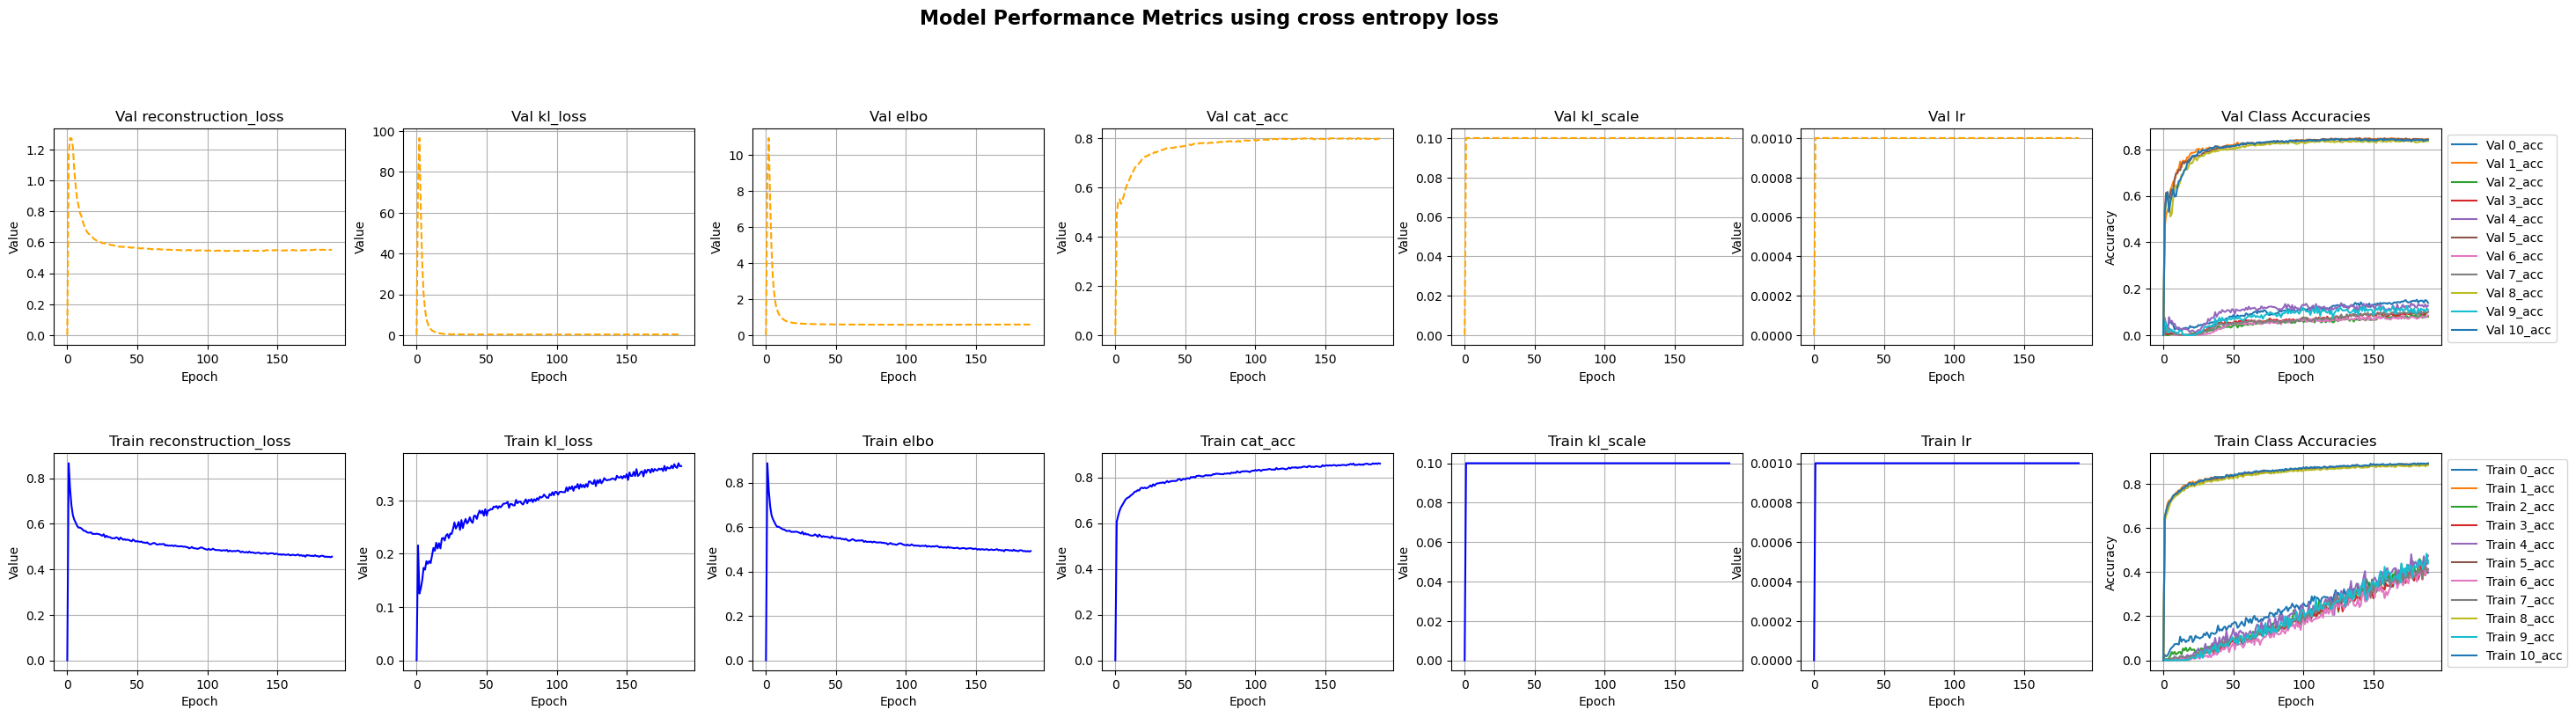

In [10]:
# Only scaled kl loss leads to some cat learning
# deep encoder showed promissing results in train dataset, retrain with drop reg

train_stats = train_and_get_results(focal_model, epochs = 189,
    base_dir = cur_base_dir, write_to_disk = True, files_to_backup = files_to_load)

In [2]:
test_pred = focal_model(geno_tensor_test)
test_pred = np.argmax(test_pred, axis = -1)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(geno_tensor_test[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_test_df = pd.concat([test_pred_df, truth_df], axis = 0)
full_test_df.to_csv(cur_base_dir + "new_pop_pred.csv")

NameError: name 'focal_model' is not defined

In [3]:
# Load stored model
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/helpers.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoder.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/decoder.py")
execfile("./data/var_autoencoder/with_unseen_children_vanilla_vae/autoencoder.py")

loaded_model = keras.models.load_model(
    "./data/var_autoencoder/with_unseen_children_vanilla_vae/with_unseen_children_vanilla_vae.keras",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "autoencoder" : autoencoder,
        "elbo_loss" : elbo_loss, "rec_loss_fn" : rec_loss_fn, "feature_drop_layer": feature_drop_layer}
)
cur_model = loaded_model

NameError: name 'np' is not defined

In [4]:
# Store encoded data for embedding analysis

encoded_data = cur_model.encoder(geno_tensor)
encoded_data_df = pd.DataFrame(encoded_data[0].numpy())
child_geno_data.iloc[train_pops_idx, 2:-2].to_numpy()
encoded_data_df["individual"] = child_geno_data["individual"].to_numpy()
encoded_data_df["pop"] = child_geno_data["pop"].to_numpy()
encoded_data_df["p1_id"] = child_geno_data["p1_id"].to_numpy()
encoded_data_df["p2_id"] = child_geno_data["p2_id"].to_numpy()
# encoded_data_df.to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_mean_all_samples.csv", index = False)
#
encoded_data_df = pd.DataFrame(encoded_data[1].numpy())
encoded_data_df["individual"] = child_geno_data["individual"].to_numpy()
encoded_data_df["pop"] = child_geno_data["pop"].to_numpy()
encoded_data_df["p1_id"] = child_geno_data["p1_id"].to_numpy()
encoded_data_df["p2_id"] = child_geno_data["p2_id"].to_numpy()
# encoded_data_df.to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_logvar_all_samples.csv", index = False)

NameError: name 'cur_model' is not defined

In [ ]:
decoded_data = cur_model.decoder(geno_tensor[:, 1:3, ...],
                                   cur_model.sample_z(encoded_data[0], encoded_data[1]))

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
decoded_data_df = pd.DataFrame(np.argmax(decoded_data.numpy(), axis = -1))
decoded_data_df.replace(list(range(len(all_geno_combs))), all_geno_combs, inplace=True)
decoded_data_df["individual"] = child_geno_data["individual"]
decoded_data_df["pop"] = child_geno_data["pop"]
decoded_data_df.to_csv("decoded_genos_all_samples.csv")

In [ ]:
true_classes = np.argmax(geno_tensor_test[:, 0, ...], axis = -1)
pred_classes = np.argmax(cur_model(geno_tensor_test), axis = -1)
marker_acc = np.sum(pred_classes == true_classes, axis = 1)/pred_classes.shape[1]
marker_var = np.var(pred_classes == true_classes, axis = 1)/pred_classes.shape[1]

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'autoencoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
y = np.vstack([marker_acc[np.argsort(marker_acc)], marker_var[np.argsort(marker_acc)]])
x = range(y.shape[1])

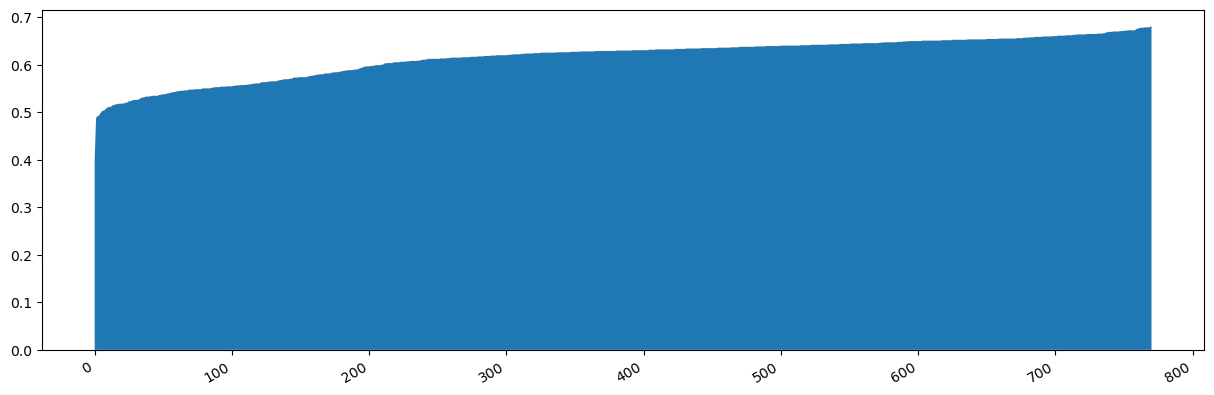

In [ ]:
# Accuracy per feature
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.stackplot(x, y)

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.rcParams['figure.figsize'] = [8, 5]

# Prediction per population

In [ ]:
geno_np_arr = np.stack(geno_np_layers, axis = -1)

In [ ]:
# Loop through populations in dataset and store genotype reconstruction accuracies
def class_acc_per_pop(model, data, sample_pops):
    pops = []
    class_accs_in_oop = {class_id: [] for class_id in range(data.shape[-1])}
    for cur_pop in np.unique(pop_per_sample):
        pop_idx = sample_pops == cur_pop
        pops.append(cur_pop)
        cur_geno_tensor = data[pop_idx, ...]
        pred = model(cur_geno_tensor)
        true_classes = tf.argmax(cur_geno_tensor[:, 0, ...], axis = -1)
        for class_id in range(pred.shape[-1]):

            class_pred = tf.equal(tf.argmax(pred, axis = -1), class_id)
            class_y = tf.equal(true_classes, class_id)
            correct_pred = tf.cast(tf.logical_and(class_pred, class_y), tf.int32)

            acc = tf.reduce_sum(correct_pred)/tf.reduce_sum(tf.cast(class_y, tf.int32))
            class_accs_in_oop[class_id].append(acc.numpy())    
    res = pd.DataFrame(class_accs_in_oop)
    res["pop"] = pops
    return res

In [ ]:
res_df = class_acc_per_pop(cur_model, geno_np_arr, pop_per_sample)
res_df["data_type"] = "train"
res_df.loc[np.isin(res_df["pop"], test_pops), "data_type"] = "oop"

In [ ]:
eval_df = class_acc_per_pop(cur_model, geno_tensor_eval.numpy(), eval_pops)
eval_df["data_type"] = "eval"

In [ ]:
pd.concat([res_df, eval_df]).to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/acc_per_pop.csv")